In [1]:
# Standard Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
# TODO: Add sklearnex to improve performance
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split

# Global variables
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
start_year = 1993
curr_year = datetime.now().year

In [2]:
# Custom API
from sys import path

path.append('../API/eda')
from data_visualizations import get_yearly_base_rates, get_seed_pairs, format_plot

path.append('../API/fetch')
import data_fetch as fetch

path.append('../API/model')
from model_selection import get_cv_models
from model_evaluation import evaluate_cv_models, model_predictions, get_classification_report

path.append('../API/preprocess')
from feature_engineering import create_bracket_winners
from data_integrity import season_team_to_coach_tourney_team_dict
from data_clean import clean_basic_stats, clean_tourney_data
from data_pipeline import dataset_pipeline, feature_pipeline, bracket_pipeline

# Data Fetching

## Perceived Predictors

Naturally, it will be vitally important to scrape available data that is pertinent to deciding the outcome of an NCAA March Madness game between any two given teams. To successfully do so, we must break down what are generally the most influential elements of a basketball team's success.

<br>Overall team performance during the regular season is generally a good indicator of how a team will perform in March Madness. This would be captured by statistics, both basic and advanced, such as the following:
<br>**Season Record (%)
<br>Conference Record (%); could be important given that the tournament is split into regions
<br>Regular Season Record vs. Tourney Opponent (%); set to theoretical discrete probability of 50% if no such matchups exist 
<br>Strength of Schedule (SOS); measures the difficulty of the teams played (higher number = greater difficulty)
<br>Top 25 Ranking (boolean); considered a consensus top-tier team
<br>Shots Made per Game (FG, 3P, FT)
<br>Point Differential per Game; measures how dominant/unsuccessful you are at outscoring your opponent on average
<br>Misc. Team Stats per Game (Rebounds, Assists, Blocks, etc.)**

<br>It's important to note that in the NCAA, more so than the NBA, experienced coaches can have just as much of an impact on a game's outcome as the players themselves. Hence, it's reasonable to assume that the following statistics could also be solid indicators:
**<br>Coach March Madness Appearances
<br>Coach Sweet Sixteen Appearances
<br>Coach Final Four Appearances
<br>Coach Championships Won**

<br>And lastly, we need the data for the structure of the tournaments themselves:
**<br>Favorite Seed
<br>Underdog Seed
<br>Round Number (0-6)
<br>Game Outcome (boolean); did the underdog upset the favorite?**

## Examples

Previous years permitted the provision of examples as to how the predictors listed above were scraped. However, due to request rate limit restrictions from SportsReference, the inclusion of these examples in the research notebook has been discontinued.

# Data Pipeline

Below is the output of a merge of the datasets displayed above (after they've been cleaned). Once we remove the features with nulls that won't be imputed, we can begin our exploratory data analysis (EDA).

## Tournament Games Dataset

In [3]:
# Check if the historical data CSV exists, if it doesn't then create it
prev_year = curr_year-1

try:
    mm_matchups_df = pd.read_csv(f'{curr_year}_march_madness_hist_data.csv')
except FileNotFoundError:
    hist_matchups_df = pd.read_csv(f'../{prev_year}/{prev_year}_march_madness_hist_data.csv')
    curr_matchups_df = dataset_pipeline([prev_year])
    
    mm_matchups_df = pd.concat([hist_matchups_df, curr_matchups_df])
    mm_matchups_df.to_csv(f'{curr_year}_march_madness_hist_data.csv', index=False)

mm_matchups_df

,Year,Round,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Underdog_Upset,G_Favorite,W-L%_Favorite,SRS_Favorite,...,eFG%_Underdog,TOV%_Underdog,ORB%_Underdog,FT/FGA_Underdog,Conf_Underdog,Top_25_Underdog,MM_Underdog,S16_Underdog,F4_Underdog,Champs_Underdog
0,1993,First Round,1,UNC,16,East Carolina,0,38.0,0.895,29.04,...,0.465,17.3,NaN,0.248,CAA,0.0,1.0,0.0,0.0,0.0
1,1993,Second Round,1,UNC,8,Rhode Island,1,38.0,0.895,29.04,...,0.484,16.4,NaN,0.324,A-10,0.0,1.0,0.0,0.0,0.0
2,1993,Sweet Sixteen,1,UNC,4,Arkansas,0,38.0,0.895,29.04,...,0.539,15.9,NaN,0.243,SEC,1.0,9.0,3.0,1.0,0.0
3,1993,Elite Eight,1,UNC,2,Cincinnati,0,38.0,0.895,29.04,...,0.512,16.9,NaN,0.222,GMWC,1.0,3.0,2.0,1.0,0.0
4,1993,Final Four,1,UNC,2,Kansas,0,38.0,0.895,29.04,...,0.565,17.0,NaN,0.280,Big 8,1.0,4.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,2024,First Round,6,Clemson,11,New Mexico,0,36.0,0.667,16.20,...,0.505,11.7,33.4,0.234,MWC,0.0,3.0,0.0,0.0,0.0
1999,2024,First Round,3,Baylor,14,Colgate,0,35.0,0.686,19.50,...,0.538,14.1,25.3,0.186,Patriot,0.0,5.0,0.0,0.0,0.0
2000,2024,First Round,7,Dayton,10,Nevada,0,33.0,0.758,13.45,...,0.535,13.2,27.6,0.319,MWC,0.0,13.0,4.0,0.0,0.0
2001,2024,First Round,2,Arizona,15,Long Beach State,0,36.0,0.750,24.54,...,0.487,14.7,33.3,0.271,Big West,0.0,4.0,1.0,0.0,0.0


## Handling Missing Values

### Finding the Nulls

Recall that our cleaned dataset has a total of 1,877 March Madness games present, and each March Madness will consist of no more than 67 games (4 play-in games + 63 tournament games). As can be seen below, the advanced stats pertaining to personal fouls (PF) and turnovers (TOV) are the only features listed with no more than a season's worth of missing data. Given how rapidly the gameplay of college basketball has evolved over the time horizon of our dataset, imputing nulls on multiple years of March Madness data would likely be a futile effort. The features with a high volume of nulls (1> season) will be dropped from the dataset.

In [4]:
# Given that a feature has any nulls, find the number of nulls present
true_nulls = fetch.get_feature_null_counts(mm_matchups_df)
true_nulls

Pace_Underdog      1072
Pace_Favorite      1065
ORB%_Favorite       766
STL%_Favorite       766
ORtg_Favorite       766
STL%_Underdog       765
ORtg_Underdog       765
ORB%_Underdog       764
Home_W_Favorite     504
Away_L_Underdog     504
Away_W_Underdog     504
Home_L_Underdog     504
Home_W_Underdog     504
Away_L_Favorite     504
Away_W_Favorite     504
Home_L_Favorite     504
ORB_Underdog        255
ORB_Favorite        254
PF_Underdog          64
PF_Favorite          64
TOV_Underdog          3
TOV%_Underdog         3
TOV_Favorite          1
TOV%_Favorite         1
dtype: int64

In [5]:
# Get turnover features from true_nulls
tov_null_fills = [col for col in true_nulls.index if ('TOV' in col)]

# Get personal foul features from true_nulls
pf_null_fills = [col for col in true_nulls.index if ('PF' in col)]

# All other features found in true_nulls are dropped from our original dataset
null_drops = list(set(true_nulls.index) - set(tov_null_fills) - set(pf_null_fills))
mm_matchups_df.drop(null_drops, axis=1, inplace=True)

In [6]:
# View the rows containing all of the dataset's nulls to be imputed
# This will be a useful reference to validate the proper imputation of the nulls
tov_nulls_rows = fetch.get_null_rows(tov_null_fills, mm_matchups_df)
pf_nulls_rows = fetch.get_null_rows(pf_null_fills, mm_matchups_df)

display(tov_nulls_rows), display(pf_nulls_rows)

,Year,TOV_Underdog,TOV%_Underdog,TOV_Favorite,TOV%_Favorite,Underdog_Upset
51,1993,NaN,NaN,561.0,17.4,0
52,1993,NaN,NaN,373.0,15.9,1
56,1993,552.0,16.6,NaN,NaN,0
483,2000,NaN,NaN,520.0,17.8,0


,Year,PF_Underdog,PF_Favorite,Underdog_Upset
568,2002,NaN,NaN,1
569,2002,NaN,NaN,0
570,2002,NaN,NaN,0
571,2002,NaN,NaN,0
572,2002,NaN,NaN,0
...,...,...,...,...
627,2002,NaN,NaN,0
628,2002,NaN,NaN,0
629,2002,NaN,NaN,0
630,2002,NaN,NaN,0


(None, None)

### What are the Distributions of the Features We Wish to Impute?

Upon looking at the distributions below of all turnover and personal foul features, we can see that they closely resemble a normal distribution. Given this assumption, the features' means will serve as good values for imputing the nulls.

1993 feature distributions
2000 feature distributions


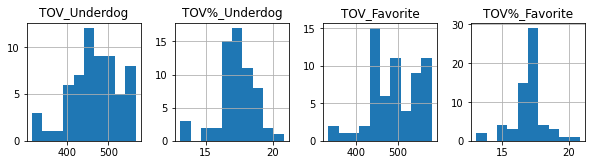

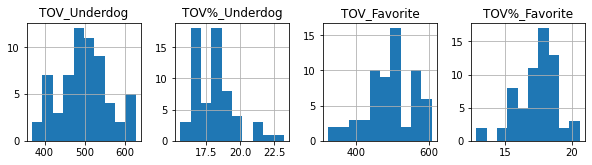

In [7]:
# View the distributions of the dataset's turnover features
tov_null_years = sorted(list(set(tov_nulls_rows['Year'])))

for year in tov_null_years:
    print(f"{year} feature distributions")
    year_df = mm_matchups_df[mm_matchups_df['Year'] == year]
    year_df[tov_null_fills].hist(figsize=(10, 5), layout=(len(tov_null_years), len(tov_null_fills)))

array([[<AxesSubplot:title={'center':'PF_Underdog'}>,
        <AxesSubplot:title={'center':'PF_Favorite'}>]], dtype=object)

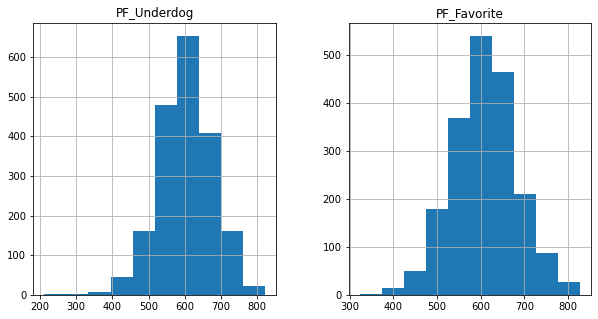

In [8]:
# View the distributions of the dataset's personal foul features
pf_null_years = sorted(list(set(pf_nulls_rows['Year'])))

mm_matchups_df[pf_null_fills].hist(figsize=(10, 5), layout=(1, len(pf_null_fills)))

### Impute TOV Nulls by Season & Target Variable

In [9]:
# Retrieve TOV feature means by season; only include seasons that contain nulls
tov_col_means = mm_matchups_df[tov_nulls_rows.columns].groupby(['Year', 'Underdog_Upset']).mean()
tov_col_means.loc[tov_null_years]

TOV_Underdog  TOV%_Underdog  TOV_Favorite  TOV%_Favorite
Year Underdog_Upset                                                          
1993 0                 463.044444      17.360000    496.666667      16.984444
     1                 475.937500      17.056250    481.941176      17.282353
2000 0                 492.704545      18.336364    507.733333      17.511111
     1                 511.000000      17.544444    468.944444      17.066667

In [10]:
for year in tov_null_years:
    for label in [0, 1]:
        for col in tov_null_fills:
            # Get feature's rows with nulls for given year & label type
            fill_condition = (tov_nulls_rows['Year'] == year) & (tov_nulls_rows['Underdog_Upset'] == label)
            col_fill_rows = tov_nulls_rows[fill_condition].index
            # Get feature's mean for given year
            col_year_mean = np.round(tov_col_means.loc[(year, label), col], 1)
            # Impute nulls of interest
            mm_matchups_df.loc[col_fill_rows, col] = mm_matchups_df.loc[col_fill_rows, col].fillna(col_year_mean)

# Display rows that originally had nulls to see if they match discovered feature means
mm_matchups_df.loc[tov_nulls_rows.index, tov_null_fills]

,TOV_Underdog,TOV%_Underdog,TOV_Favorite,TOV%_Favorite
51,463.0,17.4,561.0,17.4
52,475.9,17.1,373.0,15.9
56,552.0,16.6,496.7,17.0
483,492.7,18.3,520.0,17.8


### Impute PF Nulls by Target Variable Using Entire Distribution

In [11]:
# Retrieve PF feature means; only found in one season
pf_col_means = mm_matchups_df[pf_nulls_rows.columns].groupby(['Underdog_Upset']).mean()
pf_col_means.drop('Year', axis=1)

,PF_Underdog,PF_Favorite
Underdog_Upset,,
0,594.605719,615.723853
1,617.334426,594.827869


In [12]:
for label in [0, 1]:
    for col in pf_null_fills:
        # Get feature's rows with nulls for given year & label type
        fill_condition = (pf_nulls_rows['Underdog_Upset'] == label)
        col_fill_rows = pf_nulls_rows[fill_condition].index
        # Get feature's mean
        col_mean = np.round(pf_col_means.loc[label, col], 1)
        # Impute nulls of interest
        mm_matchups_df.loc[col_fill_rows, col] = mm_matchups_df.loc[col_fill_rows, col].fillna(col_mean)
    
# Display rows that originally had nulls to see if they match discovered feature means
mm_matchups_df.loc[pf_nulls_rows.index, pf_null_fills]

,PF_Underdog,PF_Favorite
568,617.3,594.8
569,594.6,615.7
570,594.6,615.7
571,594.6,615.7
572,594.6,615.7
...,...,...
627,594.6,615.7
628,594.6,615.7
629,594.6,615.7
630,594.6,615.7


# Exploratory Data Analysis (EDA)

As any good data scientist should do, there are a few questions I hope to address in my EDA:
 - What is our bracket's accuracy if we guess the favorite always wins?
 - How often do upsets occur in a given year's March Madness?
 - What is the distribution of upsets across the tournament rounds?
 - Which seeding combinations are most likely to produce upsets?

## What is our Bracket's Accuracy if We Guess the Favorite Always Wins?

This is a strategy many of us have employed at least once while filling out a March Madness bracket, myself included. This is a classic EDA question which explores the idea of the base rate: historically, how often would we be right if we always assumed the favorite won the March Madness matchup? ~68.7% of our predictions would be correct according to our data, approximately 2 out of every 3 games. This means that for any model to be of value to us, it must demonstrate >68.7% of its predictions are correct.

In college basketball, the best (and thus most impactful) players typically leave the NCAA after no more than 2 years. Thus, a 2-year moving average was chosen to illustrate the base rate's trends as new impactful players participate in March Madness. Our base rate is maintained fairly consistently over time, with a few exceptions scattered across the dataset's time horizon.

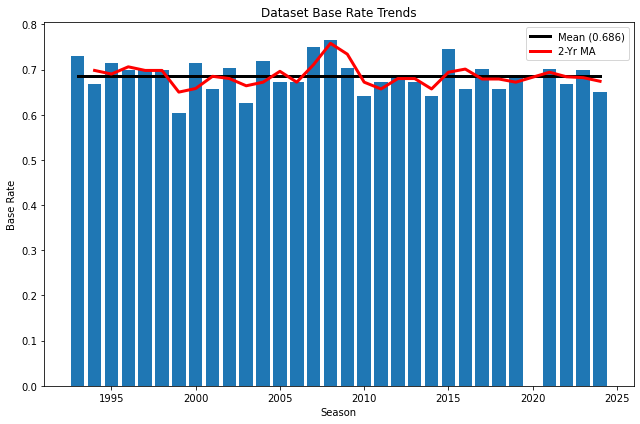

In [13]:
# Each season's base rate
yearly_base_rates = get_yearly_base_rates(mm_matchups_df)
# Dataset's mean base rate
mean_base_rate = np.round(yearly_base_rates.mean(), 3)
# Moving average
years_ma = 2
base_rate_ma = np.round(yearly_base_rates.rolling(years_ma).mean(), 3)

# Plot findings
plt.figure(figsize=(9, 6))

plt.plot(yearly_base_rates.index, [mean_base_rate] * len(yearly_base_rates), color='k', linewidth=3, label=f'Mean ({mean_base_rate})')
plt.plot(yearly_base_rates.index, base_rate_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_base_rates.index, yearly_base_rates)

format_plot(title='Dataset Base Rate Trends', xlabel='Season', ylabel='Base Rate')

## How Often Do Upsets Occur in a Given Year's March Madness?

If favorites win March Madness matchups ~68.7% of the time, then we can conclude the underdogs are winning the other 31.3%; this translates to approximately 20 upsets per year. This knowledge gives us insight into how many upsets we should expect our model to predict (i.e. 25 is likely too high, 15 is likely too low).

A 2-year moving average has been employed once again to highlight the trends present across the dataset's time horizon. At first it may appear to be more volatile than the base rate trends, but this is simply due to the scale of the y-axis.

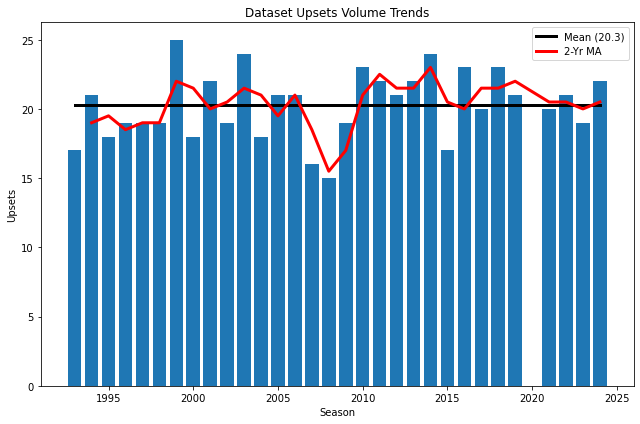

In [14]:
# Each season's upset count
yearly_upsets = mm_matchups_df.groupby('Year').agg({'Underdog_Upset': 'sum'})
# Dataset's mean upset count
mean_upsets = np.round(yearly_upsets['Underdog_Upset'].mean(), 1)
# Moving average
upsets_ma = np.round(yearly_upsets.rolling(years_ma).mean(), 1)

# Plot findings
plt.figure(figsize=(9, 6))

plt.plot(yearly_upsets.index, [mean_upsets] * len(yearly_upsets), color='k', linewidth=3, label=f'Mean ({mean_upsets})')
plt.plot(yearly_upsets.index, upsets_ma, color='r', linewidth=3, label=f'{years_ma}-Yr MA')
plt.bar(yearly_upsets.index, yearly_upsets['Underdog_Upset'])

format_plot(title='Dataset Upsets Volume Trends', xlabel='Season', ylabel='Upsets')

## What is the Distribution of Upsets Across the Tournament Rounds?

Of the 20 upsets that we can expect in any given March Madness, the visualization below gives us an idea of how many upsets we can expect in each round. Nearly 70% of all upsets happen in the first 2 rounds, which is sensible given that 75% of all games are held in the first 2 rounds. Fewer upsets in each successive round is expected not only because of a diminished volume of games, but also a greater saturation of top-tier teams amongst the remaining teams in contention. We should expect our model to follow a similar pattern.

In [15]:
# Retrieve data about March Madness matchup seed pairings
seed_pairs = get_seed_pairs(mm_matchups_df)
# Extract seed pairs that resulted in upsets
upset_pairs = seed_pairs[seed_pairs['Underdog_Upset'] == 1]

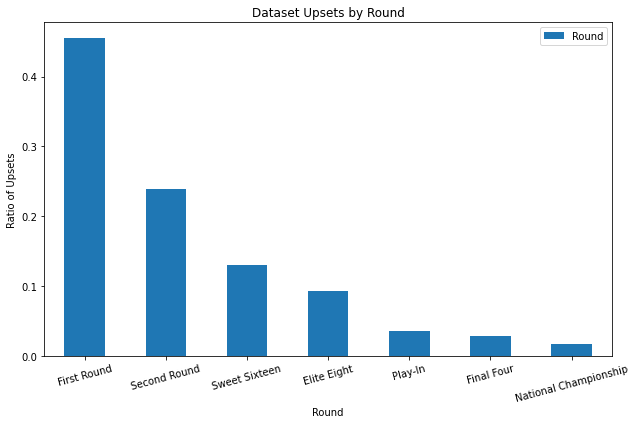

In [16]:
# Group upset seed pairs by round and count them
upset_rounds_freq = upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Dataset Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')

## Which Seeding Combinations are the Most Likely to Produce Upsets?

Suppose our model predicts 12 upsets in the first round, even though we should only expect 9 according to our EDA. In the event this type of situation arises, it'd be valuable to know which seed pairings are most likely to produce upsets so we could discard 3 of the 12 first round upsets with the lowest upset likelihoods.

Only the top 25 upset likelihoods are shown because our EDA also revealed we should expect no more than 25 upsets in a given year. We can see once again that the overwhelming majority of upsets occur in the first round, particularly in the 4 seed pairings that are the most evenly matched (Seeds 8 vs. 9 through Seeds 5 vs. 12). Our model should emulate this behavior fairly closely in its upset predictions.

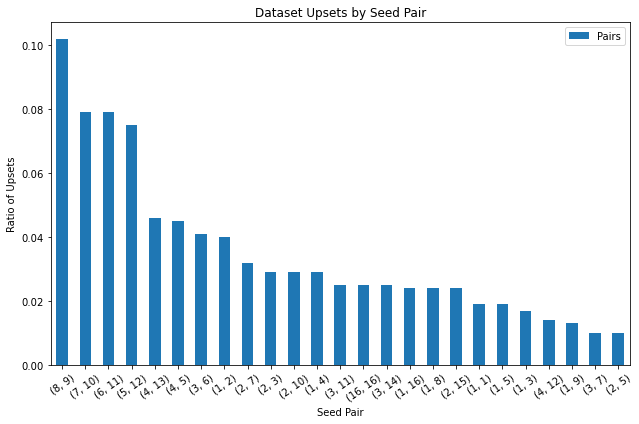

In [17]:
# Group upsets by seed pairing and count them
upset_pairs_freq = np.round(upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)

# Plot findings
upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Dataset Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

# Feature Engineering & Analysis

Below we can see our original feature matrix (X) and then our feature matrix prepped for model fitting (prep_all_X). This transformation is performed by passing X through the feature pipeline. 

One of the primary actions that transpires in the pipeline is subtracting the favorites' stats from the underdogs' stats in each matchups to create underdog-relative features. This not only retains virtually all of our potential information gain, but also improves computation speed and reduces the likelihood of high variance and thus overfitting the data.

The second primary action is the scaling of our numerical features. This conversion of all numerical features to a normal distribution is important because it eliminates the possibility of features' number ranges negatively influencing a model's learning process.

In [18]:
# Drop unneeded features
mm_matchups_df.drop(['Year', 'Team_Favorite', 'Team_Underdog'], axis=1, inplace=True)
# Store rounds data (for EDA visualizations)
all_rounds = mm_matchups_df['Round']

# Create feature matrix and target variable
X = mm_matchups_df.drop('Underdog_Upset', axis=1)
y = mm_matchups_df['Underdog_Upset']

display(X), display(y)

,Round,Seed_Favorite,Seed_Underdog,G_Favorite,W-L%_Favorite,SRS_Favorite,Conf_W_Favorite,Conf_L_Favorite,FG_Favorite,FG%_Favorite,...,BLK%_Underdog,eFG%_Underdog,TOV%_Underdog,FT/FGA_Underdog,Conf_Underdog,Top_25_Underdog,MM_Underdog,S16_Underdog,F4_Underdog,Champs_Underdog
0,First Round,1,16,38.0,0.895,29.04,14.0,2.0,1219.0,0.506,...,5.9,0.465,17.3,0.248,CAA,0.0,1.0,0.0,0.0,0.0
1,Second Round,1,8,38.0,0.895,29.04,14.0,2.0,1219.0,0.506,...,6.9,0.484,16.4,0.324,A-10,0.0,1.0,0.0,0.0,0.0
2,Sweet Sixteen,1,4,38.0,0.895,29.04,14.0,2.0,1219.0,0.506,...,7.2,0.539,15.9,0.243,SEC,1.0,9.0,3.0,1.0,0.0
3,Elite Eight,1,2,38.0,0.895,29.04,14.0,2.0,1219.0,0.506,...,7.3,0.512,16.9,0.222,GMWC,1.0,3.0,2.0,1.0,0.0
4,Final Four,1,2,38.0,0.895,29.04,14.0,2.0,1219.0,0.506,...,6.5,0.565,17.0,0.280,Big 8,1.0,4.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1998,First Round,6,11,36.0,0.667,16.20,11.0,9.0,991.0,0.469,...,13.2,0.505,11.7,0.234,MWC,0.0,3.0,0.0,0.0,0.0
1999,First Round,3,14,35.0,0.686,19.50,11.0,7.0,967.0,0.483,...,10.1,0.538,14.1,0.186,Patriot,0.0,5.0,0.0,0.0,0.0
2000,First Round,7,10,33.0,0.758,13.45,14.0,4.0,831.0,0.474,...,11.0,0.535,13.2,0.319,MWC,0.0,13.0,4.0,0.0,0.0
2001,First Round,2,15,36.0,0.750,24.54,15.0,5.0,1124.0,0.484,...,12.2,0.487,14.7,0.271,Big West,0.0,4.0,1.0,0.0,0.0


0       0
1       1
2       0
3       0
4       0
       ..
1998    0
1999    0
2000    0
2001    0
2002    0
Name: Underdog_Upset, Length: 2003, dtype: int64

(None, None)

In [19]:
"""We'll stratify the 80-20 split of our training & test datasets according to the target
variable's distribution so our model can learn the trends observed in our EDA"""
# Drop round data because it's already stored in previous notebook cell
X.drop('Round', axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, 
                                                    stratify=pd.concat([y, all_rounds], axis=1))

# All datasets will be scaled based on fit found for training dataset
basic_stats_df = fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/men/{year}-school-stats.html",
                                     attrs={'id': 'basic_school_stats'})
basic_stats_cols = clean_basic_stats(basic_stats_df).columns
data_cuts = {    
    'FULL': X,
    'TRAIN': X_train,
    'TEST': X_test,
}

# Pass datasets through feature pipeline to prep them for model fitting
prep_X_train = feature_pipeline('TRAIN', data_cuts, basic_stats_cols)
prep_X_test = feature_pipeline('TEST', data_cuts, basic_stats_cols)

prep_all_X = pd.concat([prep_X_train, prep_X_test])
prep_all_X

,Seed_Favorite,Seed_Underdog,Underdog_Rel_3P%,Underdog_Rel_G,Underdog_Rel_FT/Game,Underdog_Rel_SRS,Underdog_Rel_TRB/Game,Underdog_Rel_AST/Game,Underdog_Rel_W-L%,Underdog_Rel_AST%,...,Underdog_Rel_PF/Game,Underdog_Rel_Conf_W-L%,Underdog_Rel_FG%,Underdog_Rel_FG/Game,Underdog_Rel_F4,Underdog_Rel_FT%,Underdog_Rel_FTr,Underdog_Rel_TS%,Conf_Favorite,Conf_Underdog
634,-0.968497,-0.255038,-0.403635,-0.611159,0.589018,0.648438,-1.825509,-0.644972,-0.656346,-0.133899,...,-0.395531,-0.703574,0.032504,-1.018749,0.066188,0.709799,1.029094,0.386478,5,10
854,0.055166,0.760045,2.198151,-1.300407,0.778398,-0.283678,-0.553864,0.479823,0.566850,-0.105378,...,0.952304,-0.518009,0.794513,0.881914,0.066188,0.103250,0.525120,1.196356,31,17
1133,1.420050,-0.255038,-0.377086,-0.266535,-1.494166,1.311303,0.346884,0.560166,-0.248614,1.135284,...,-0.197320,-0.942158,-0.920008,-0.420392,0.419634,-0.321335,-1.679765,-0.873334,40,3
315,-0.968497,1.521356,-1.598333,-2.334279,-0.395760,-2.671924,0.452855,-1.488568,-1.546700,-1.075091,...,2.656919,0.409818,-2.348775,-0.983552,0.066188,-0.927884,-0.356834,-2.523086,3,30
1917,0.396387,-1.016350,0.286635,-0.266535,-0.054875,1.249725,0.532333,1.484104,-0.797804,1.021200,...,-1.426229,-0.414092,1.302519,1.128296,0.066188,1.316348,-0.656068,1.556302,22,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183,-0.286055,0.252503,0.605221,-0.955783,-1.418414,0.164269,-0.315431,-1.368054,0.650061,-2.558180,...,1.031588,0.489346,-0.253250,1.691456,0.419634,-1.150286,-1.837257,-0.303419,3,33
1457,0.737608,0.252503,0.260086,1.111961,-0.509388,0.900786,0.717781,-0.283430,-0.889336,-1.217695,...,0.516240,-0.889140,-0.697755,0.846716,-0.640703,-0.462863,-1.286036,-0.573378,2,29
630,-0.627276,-0.762579,0.313183,-0.955783,1.119283,0.147365,-0.421401,-0.403944,0.234008,0.194092,...,0.436955,0.632496,0.508759,-0.948354,0.066188,-0.847011,2.210282,0.716428,5,0
1794,-0.286055,1.013815,-0.138147,1.111961,-1.380538,-0.963447,0.214421,-0.122745,1.357352,-0.005555,...,-0.910880,1.383053,1.397770,-0.244405,-0.287257,-0.705483,-0.372583,0.956392,5,27


### What are the Distributions of all our Features?

The illustration below shows us the impact of the feature scaling mentioned earlier. Our features are predominantly normally distributed.

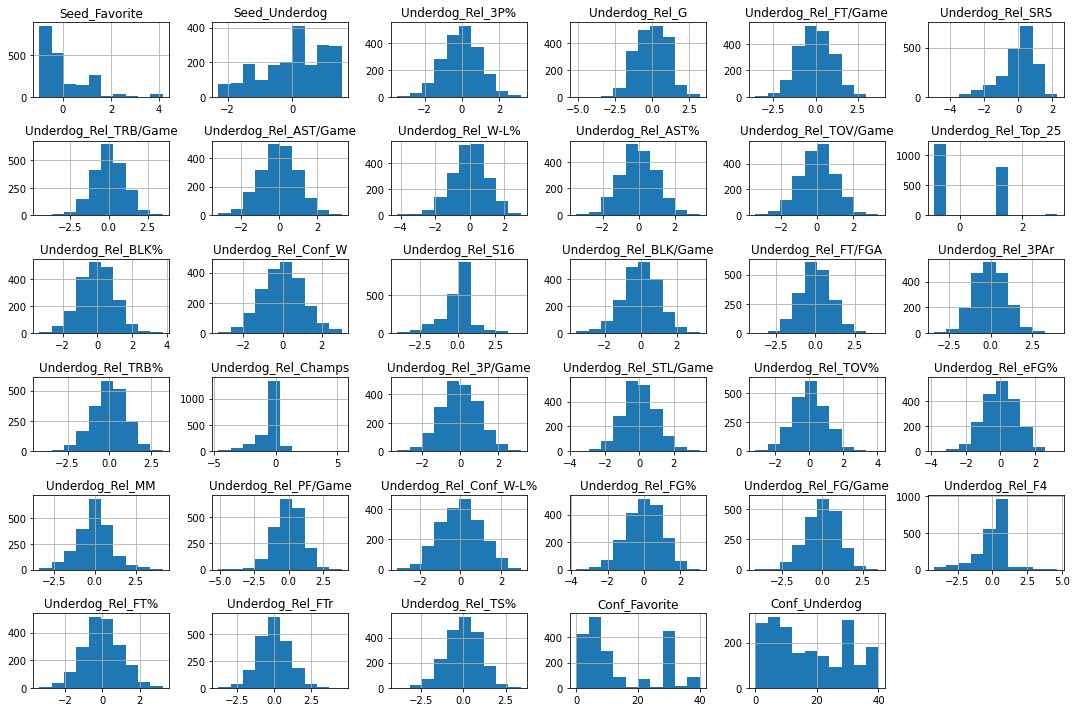

In [20]:
prep_all_X.hist(figsize=(15, 10))
plt.tight_layout()

### What Features have the Greatest Predictive Power?
The plot below represents an important concept in data science & machine learning: normalized information gain. It's a ratio of how much predictive power can be attributed to each feature in a feature matrix; these values should sum to 1, or 100% of the predictive power.

We can see underdog relative games (Underdog_Rel_G) has a staggering lead over the remaining features - 15+% of predictive power can be attributed to that one feature alone! This is sensible because it highlights how March Madness matchup favorites play more games together than their underdog opponents, which gives them more experience. This strong predictive power likely impacted our predictions in a negative way for the inaugural 2020-21 tourney because of the COVID-19 pandemic's distortion of team schedules, but that should no longer be a factor. The remaining dominant features are equally sensible.

No handles with labels found to put in legend.


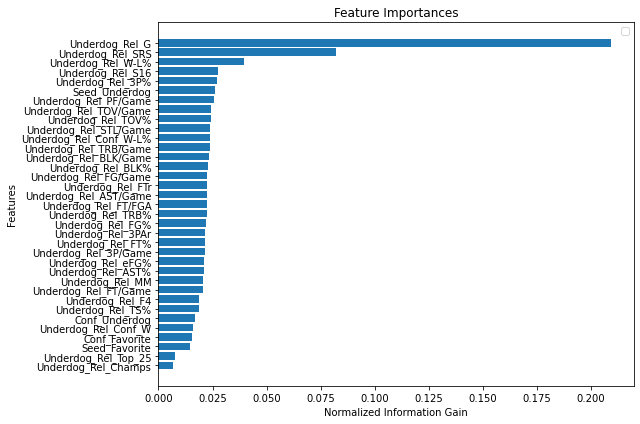

In [21]:
# Fit data to a Random Forest to find feature importances
rf = RandomForestClassifier().fit(prep_X_train, y_train)

# Sort features & their corresponding values in by importance
importances = rf.feature_importances_
feat_importances = prep_all_X.columns[np.argsort(importances)]
feat_values = np.sort(importances)

# Plot findings
plt.figure(figsize=(9, 6))
plt.barh(feat_importances, feat_values)

format_plot(title='Feature Importances', xlabel='Normalized Information Gain', ylabel='Features')

### What are the Correlations Between Features?

Though correlation differs from information gain, we still see the same features dominating the landscape. Even more interesting is that they're dominating to approximately the same degree that they were in our information gain plot above.

No handles with labels found to put in legend.


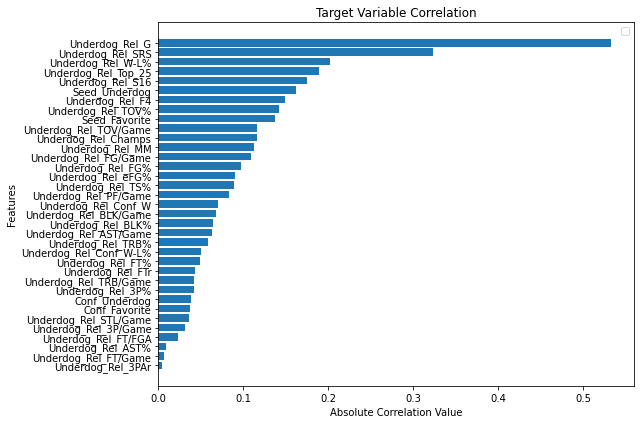

In [22]:
# Get feature matrix's correlations to target variable, then sort by absolute value
prep_X_y = prep_X_train.merge(y_train, left_index=True, right_index=True)
abs_desc_corr = np.abs(prep_X_y.corr().loc['Underdog_Upset']).sort_values()
abs_desc_corr.drop('Underdog_Upset', inplace=True)

# Plot findings
plt.figure(figsize=(9, 6))
plt.barh(abs_desc_corr.index, abs_desc_corr.values)

format_plot(title='Target Variable Correlation', xlabel='Absolute Correlation Value', ylabel='Features')

# Model Selection

### Cross-Validation

1,877 total records in a dataset isn't much, so it was necessary to employ cross-validation (CV) on the training dataset to simulate the presence of a validation set. I saw from a quick online search that a 60%-20%-20% training-validation-test set split was ideal, which required me to perform 4 CVs in my grid and randomized searches.

The models were evaluated based solely upon both the Accuracy metric, with the Random Forest (RF) and XGBoost models as the frontrunners. All factors considered, I believe the RF model is the appropriate model selection given its reduced overfitting likelihood compared to XGBoost.

In [23]:
%%time

# Perform CV on chosen models with the training set, then assess their respective performances
cv_models = get_cv_models(y)
model_performance = evaluate_cv_models(cv_models, prep_X_train, y_train)
     
model_performance

Wall time: 3min 27s


,Best_Mean_Accuracy,Best_Mean_Accuracy_Std
Naive Bayes,0.721,0.015
LogReg,0.821,0.014
SVM,0.816,0.015
Random Forest,0.816,0.012
XGBoost,0.828,0.011


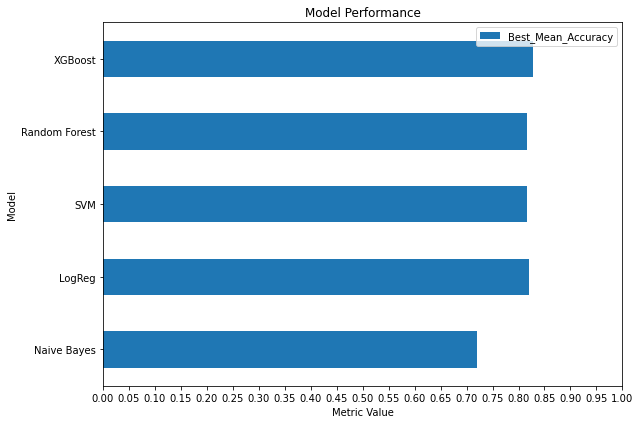

In [24]:
# Plot the performance of each model against the Accuracy metric
model_performance['Best_Mean_Accuracy'].plot(figsize=(9, 6), kind='barh', xticks=np.arange(0, 1.01, 0.05))

format_plot(title='Model Performance', xlabel='Metric Value', ylabel='Model')

In [25]:
# Identify best model to use
selected_model = 'XGBoost'

best_model = cv_models[selected_model][-1].best_estimator_
# best_model.fit(prep_X_train, y_train)

best_params = cv_models[selected_model][-1].best_params_
display(best_params)

{'n_estimators': 61,
 'learning_rate': 0.05,
 'subsample': 0.5,
 'tree_method': 'gpu_hist',
 'sampling_method': 'gradient_based',
 'lambda': 100,
 'eval_metric': 'error',
 'verbosity': 0,
 'seed': 42}

# Model Evaluation

The distribution of the predicted upsets across the tournament rounds in our test set is very similar to the true target variable values we observed in our original dataset. The upsets by seed pairing also shows strong similarities to our original dataset's trends.

The confusion matrix at the end of this section allows us to see how this model performs in relation to precision (false positives; type I error) and recall (false negatives; type II error). Interestingly, the recall for predicting an upset (Underdog_Upset == 1) is once again the only underperforming metric. This suggests our model could be a little conversative and not pick upsets when it actually should, so that's important to keep in mind as we transition into making predictions for this year's March Madness matchups.

In [26]:
# Concatenate all visualization data into a single DataFrame
test_game_data = pd.concat([y_test, all_rounds, mm_matchups_df[['Seed_Favorite', 'Seed_Underdog']]], 
                           join='inner', axis=1).drop('Underdog_Upset', axis=1)

# Overwrite the actual target variable (used for the join) with the best model's predictions
y_preds = model_predictions(best_model, prep_X_test)
test_game_data['Underdog_Upset'] = y_preds

# Get seed pairs data
test_seed_pairs = get_seed_pairs(test_game_data)
# Extract seed pairs that resulted in upsets
test_upset_pairs = test_seed_pairs[test_seed_pairs['Underdog_Upset'] == 1]

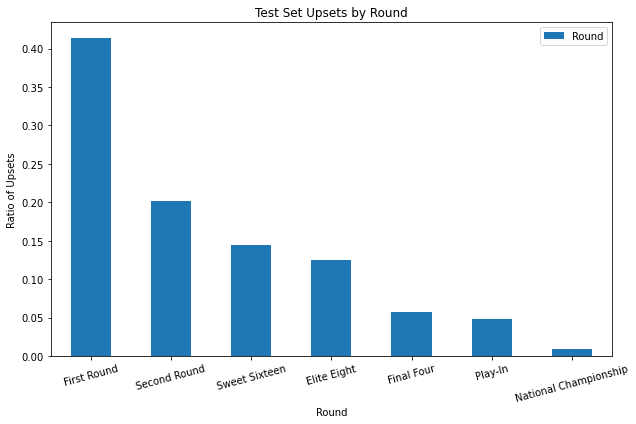

In [27]:
# Group upset seed pairs by round and count them
test_upset_rounds_freq = test_upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
test_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=15)

format_plot(title='Test Set Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')

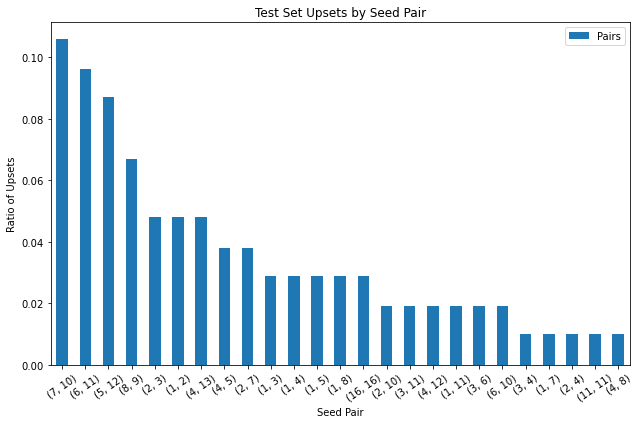

In [28]:
# Group upsets by seed pairing and count them
test_upset_pairs_freq = np.round(test_upset_pairs['Pairs'].value_counts(normalize=True)[:25], 3)

# Plot findings
test_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Test Set Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

In [29]:
# Show confusion matrix for model's test set predictions
test_set_report = get_classification_report(y_test, y_preds)
print("Test Set Metrics Report \n\n", test_set_report)

Test Set Metrics Report 

               precision    recall  f1-score   support

           0       0.82      0.89      0.86       274
           1       0.72      0.59      0.65       127

    accuracy                           0.80       401
   macro avg       0.77      0.74      0.75       401
weighted avg       0.79      0.80      0.79       401



# 2025 March Madness Predictions

## Data Pipeline

We first scrape ESPN for the starting matchups in the play-in and the first round. We then automate the prediction of all rounds in the March Madness bracket. In short, the winners predicted from the first round (filled with predicted play-in winners) are reformatted to create matchups for the second round. Those second round winners are then reformatted into the third round, and so on until a champion is crowned.

In [30]:
# Check if the starting bracket CSV exists, if it doesn't then create it
try:
    curr_bracket_df = pd.read_csv(f'{curr_year}_march_madness_curr_start_bracket.csv')
except FileNotFoundError:
    curr_bracket_df = fetch.get_current_bracket(curr_year)
    curr_bracket_df.to_csv(f'{curr_year}_march_madness_curr_start_bracket.csv', index=False)
    raise ValueError("Manually add First Four matchups to starting bracket before resuming program execution")

# Extract play-in matchups
play_in = curr_bracket_df[:4]

# Extract first round matchups
first_round = curr_bracket_df[4:]
first_round.index = range(len(first_round))

display(play_in), display(first_round)

,Seed,Team,Seed.1,Team.1
0,16,Mount St. Mary's,16,American
1,11,Xavier,11,Texas
2,16,Saint Francis (PA),16,Alabama State
3,11,UNC,11,San Diego State


,Seed,Team,Seed.1,Team.1
0,1,Duke,0,NaN
1,8,Mississippi State,9,Baylor
2,5,Oregon,12,Liberty
3,4,Arizona,13,Akron
4,6,BYU,11,VCU
5,3,Wisconsin,14,Montana
6,7,Saint Mary's,10,Vanderbilt
7,2,Alabama,15,Robert Morris
8,1,Houston,16,SIU-Edwardsville
9,8,Gonzaga,9,Georgia


(None, None)

In [31]:
# Create DataFrame with all March Madness predictions
bracket_preds = bracket_pipeline(curr_year, play_in, first_round, best_model, data_cuts, null_drops)

# Display bracket_pipeline() predictions by round
for _round in bracket_preds['Round'].unique():
    display(bracket_preds[bracket_preds['Round'] == _round])

,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
0,16,American,16,Mount St. Mary's,Play-In,0,American
1,11,Xavier,11,Texas,Play-In,1,Texas
2,16,Alabama State,16,Saint Francis (PA),Play-In,0,Alabama State
3,11,San Diego State,11,UNC,Play-In,1,UNC


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
4,1,Duke,16,American,First Round,0,Duke
5,8,Mississippi State,9,Baylor,First Round,1,Baylor
6,5,Oregon,12,Liberty,First Round,0,Oregon
7,4,Arizona,13,Akron,First Round,0,Arizona
8,6,BYU,11,VCU,First Round,1,VCU
9,3,Wisconsin,14,Montana,First Round,0,Wisconsin
10,7,Saint Mary's,10,Vanderbilt,First Round,0,Saint Mary's
11,2,Alabama,15,Robert Morris,First Round,0,Alabama
12,1,Houston,16,SIU-Edwardsville,First Round,0,Houston
13,8,Gonzaga,9,Georgia,First Round,0,Gonzaga


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
36,1,Duke,9,Baylor,Second Round,0,Duke
37,4,Arizona,5,Oregon,Second Round,0,Arizona
38,3,Wisconsin,11,VCU,Second Round,0,Wisconsin
39,2,Alabama,7,Saint Mary's,Second Round,0,Alabama
40,1,Houston,8,Gonzaga,Second Round,0,Houston
41,4,Purdue,5,Clemson,Second Round,0,Purdue
42,3,Kentucky,11,Texas,Second Round,1,Texas
43,2,Tennessee,10,Utah State,Second Round,0,Tennessee
44,1,Auburn,8,Louisville,Second Round,0,Auburn
45,4,Texas A&M,5,Michigan,Second Round,1,Michigan


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
52,1,Duke,4,Arizona,Sweet Sixteen,0,Duke
53,2,Alabama,3,Wisconsin,Sweet Sixteen,1,Wisconsin
54,1,Houston,4,Purdue,Sweet Sixteen,0,Houston
55,2,Tennessee,11,Texas,Sweet Sixteen,0,Tennessee
56,1,Auburn,5,Michigan,Sweet Sixteen,0,Auburn
57,2,Michigan State,11,UNC,Sweet Sixteen,1,UNC
58,1,Florida,4,Maryland,Sweet Sixteen,0,Florida
59,2,St. John's (NY),3,Texas Tech,Sweet Sixteen,0,St. John's (NY)


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
60,1,Duke,3,Wisconsin,Elite Eight,0,Duke
61,1,Houston,2,Tennessee,Elite Eight,0,Houston
62,1,Auburn,11,UNC,Elite Eight,1,UNC
63,1,Florida,2,St. John's (NY),Elite Eight,0,Florida


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
64,1,Duke,1,Houston,Final Four,1,Houston
65,1,Florida,11,UNC,Final Four,0,Florida


,Seed_Favorite,Team_Favorite,Seed_Underdog,Team_Underdog,Round,Underdog_Upset,Winner
66,1,Florida,1,Houston,National Championship,1,Houston


## Pre-Tournament Model Evaluation (3/19/25)

The RF model predicted 22 upsets for the upcoming tournament just like last year, a few higher than the expected number of upsets per our historical dataset EDA. This may be considered moderately aggressive behavior, causing the RF model to generate poor upset prediction precision. Alternatively, this may prove to be good decision-making on the model's part given the test set confusion matrix's indication of the model's potential for poor upset prediction recall. Only time will tell.

In [32]:
# Get seed pairs data
curr_seed_pairs = get_seed_pairs(bracket_preds)
# Extract seed pairs that resulted in upsets
curr_upset_pairs = curr_seed_pairs[curr_seed_pairs['Underdog_Upset'] == 1]

Total Upsets: 15


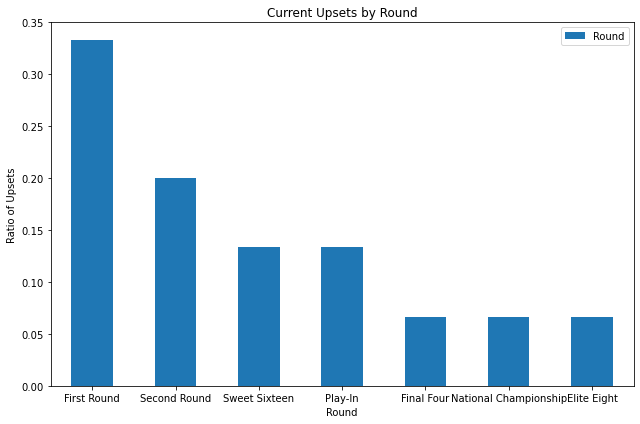

In [33]:
# Group upset seed pairs by round and count them
curr_upset_rounds_freq = curr_upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
curr_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=0)

format_plot(title='Current Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')
print(f"Total Upsets: {len(curr_upset_pairs)}")

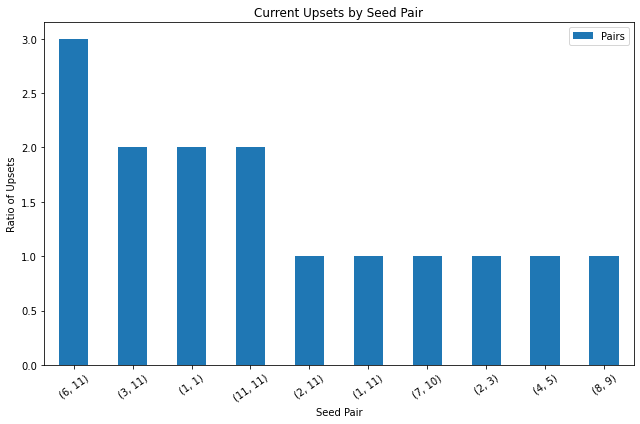

In [34]:
# Group upsets by seed pairing and count them
curr_upset_pairs_freq = curr_upset_pairs['Pairs'].value_counts()

# Plot findings
curr_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='Current Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

## Post-Tournament Model Evaluation (TBD)

### True Tournament Outcomes EDA

It's incredibly pleasing to see the results of the true tournament outcomes given how closely they mirrored the observed patterns in the historical dataset EDA. The tournament had 19 upsets in total, and the distributions of said upsets across the tournament rounds and seed pairings were comparable to what was observed in both the historical and test datasets.

In [ ]:
basic_stats_df = fetch.get_team_data(url=f"https://www.sports-reference.com/cbb/seasons/men/{curr_year}-school-stats.html",
                                     attrs={'id': 'basic_school_stats'})
clean_basic_stats_df = clean_basic_stats(basic_stats_df)

# Clean basic stats' school names to properly merge with raw tournament data
if clean_basic_stats_df['School'].str.contains('NCAA').any():
    clean_basic_stats_df['School'] = clean_basic_stats_df['School'].apply(lambda school: school[:-5])

# Create DataFrame with all March Madness outcomes
bracket_trues = clean_tourney_data(fetch.get_tourney_matchups(curr_year), clean_basic_stats_df)
create_bracket_winners(bracket_trues)

# Display true tournament results by round
for _round in bracket_trues['Round'].unique():
    display(bracket_trues[bracket_trues['Round'] == _round])

In [ ]:
# Get seed pairs data
true_seed_pairs = get_seed_pairs(bracket_trues)
# Extract seed pairs that resulted in upsets
true_upset_pairs = true_seed_pairs[true_seed_pairs['Underdog_Upset'] == 1]

In [ ]:
# Group upset seed pairs by round and count them
true_upset_rounds_freq = true_upset_pairs['Round'].value_counts(normalize=True)

# Plot findings
true_upset_rounds_freq.plot(figsize=(9, 6), kind='bar', rot=0)

format_plot(title='True Upsets by Round', xlabel='Round', ylabel='Ratio of Upsets')
print(f"Total Upsets: {len(true_upset_pairs)}")

In [ ]:
# Group upsets by seed pairing and count them
true_upset_pairs_freq = true_upset_pairs['Pairs'].value_counts()

# Plot findings
true_upset_pairs_freq.plot(figsize=(9, 6), kind='bar', rot=35)

format_plot(title='True Upsets by Seed Pair', xlabel='Seed Pair', ylabel='Ratio of Upsets')

### Compare Predicitons to True Outcomes

As can be seen below, the RF model correctly predicted 50 of the 63 possible games, resulting in an accuracy of ~79.4%! Though not nearly as substantial a jump as last year's performance of ~76.2% (48/63), I acknowledge that this marginal increase is more realistic given the law of diminishing returns.

In [ ]:
# Display correct predictions by round
correct_preds_df = pd.DataFrame(columns=['# Correct Preds', '# Possible Preds'])

for _round in bracket_trues['Round'].unique():
    # Extract round data from predictions & trues
    trues_round = bracket_trues[bracket_trues['Round'] == _round]
    preds_round = bracket_preds[bracket_preds['Round'] == _round]
    
    # Intersection of predictions & trues indicates the model's correct picks
    correct_preds = set(trues_round['Winner']).intersection(set(preds_round['Winner']))
    
    # Input data into Dataframe
    correct_preds_df.loc[_round] = [len(correct_preds), len(preds_round)]
    
correct_preds_df.loc['Tournament Total'] = [correct_preds_df['# Correct Preds'].sum(), correct_preds_df['# Possible Preds'].sum()]
    
correct_preds_df

In [ ]:
# Calculate and output the model's accuracy
print(f"Accuracy: {np.round(correct_preds_df.loc['Tournament Total', '# Correct Preds'] / len(bracket_trues), 3)}")

# Conclusion & Future Work

My machine learning approach (79.4% accuracy) once again outperformed the random guessing benchmark (68.7% accuracy)! My lifetime achievement goal was 80%, and at this rate it looks like I'll be able to make that happen in next year's tourney. So naturally, I still have some feature engineering and modeling ideas for improving performance:
- #### Additional Model Evaluation
 - I successfully implemented XGBoost for use in model evaluation, a feat I'm incredibly proud of given it being a brand new domain for me. However, I was unable to implement a deep learning neural network using tensorflow, and that's still a goal of mine to potentially aid future performance.
- #### Model Hyperparameter Tuning
 - Though the law of diminishing returns does play a factor in this year's marginal performance improvement, it may very well also be attributed to virtually no difference in the hyperparameter tuning of my models. I still need to learn how to properly tune XGBoost models and neural networks, with which I'm a novice at best. Doing so may see one of those models claiming the crown for use in future predictions, ideally with improved performance.
 
This year's March Madness Predictions machine learning project was very affirming for me. In my mind, a second consecutive year of handily beating the random guessing benchmark solidifies the legitimacy of my research and validates all the hours I've put into this personal project. The only notable difference between this year's and last year's projects was the addition of another year of tourney data to my historical dataset. More data always helps, but I have yet to exhaust all of my options for model tuning and metric optimization to continually enhance my performance. I look forward to continuing this pursuit for next year.